# Deep Learning Option Pricing

Solving the Black-Scholes Partial Differential Equation (PDE), using Physics Informed Neural Networks (PINNs), which governs the price of European options and can be derived from basic principles of hedging, risk neutrality, and no-arbitrage.

Based on following papers:

- "Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations" by Maziar Raissi, Paris Perdikaris, and George Em Karniadakis [Link: https://arxiv.org/abs/1711.10561].
- "Physics Informed Neural Network for Option Pricing" by Ashish Dhiman and Yibei Hu [Link: https://arxiv.org/html/2312.06711v1].

The code is inspired by the github repository of Alireza Afzal Afhaei
- [Link: https://github.com/alirezaafzalaghaei/PINN-tutorial]
- [Link: https://github.com/keonly/black-scholes-pinn]
- [Link: https://github.com/alialaradi/DeepGalerkinMethod]
- [Link: https://github.com/rujuldwivedi/Quant-Models]

## Key Assumptions of the Black-Scholes Model:

### 1. Geometric Brownian Motion:
The underlying asset price $S(t)$ follows a stochastic process modeled by:

$$dS(t) = \mu S(t) dt + \sigma S(t) dW(t)$$

where:
- $\mu$ is the drift rate (expected return of the asset).
- $\sigma$ is the volatility of the asset.
- $W(t)$ is a Wiener process (standard Brownian motion).

### 2. No Arbitrage:
There are no arbitrage opportunities in the market, meaning prices adjust to eliminate riskless profit opportunities.

### 3. Constant Interest Rate:
The risk-free interest rate $r$ is constant over time.

## Step 1: Setting Up a Portfolio

We construct a portfolio $\Pi$ consisting of:
- A long position in one option (value $C(S, t)$).
- A short position in $\Delta$ units of the underlying asset $S(t)$, where $\Delta$ is the hedge ratio (the option's delta).

The value of this portfolio is:

$$\Pi = C(S, t) - \Delta S(t)$$

To make the portfolio riskless (i.e., no exposure to the stochastic changes in $S$), we choose $\Delta$ to cancel out the stochastic part of the option's value, such that:

$$d\Pi = dC - \Delta dS$$

From **Ito's Lemma**, the differential of the option price $C(S, t)$ is given by:

$$dC = \frac{\partial C}{\partial t} dt + \frac{\partial C}{\partial S} dS + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2S^2dt$$

Substituting the stochastic process for $dS(t)$, we get:

$$dC = \frac{\partial C}{\partial t} dt + \frac{\partial C}{\partial S} (\mu S dt + \sigma S dW) + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2 S^2 dt$$

Now, choosing $\Delta = \frac{\partial C}{\partial S}$ (i.e., delta hedging), the stochastic terms involving $dW$ cancel out, leaving us with:

$$d\Pi = \frac{\partial C}{\partial t} dt + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2 S^2 dt$$

Since this portfolio is riskless, by the principle of no arbitrage, it must earn the risk-free rate $r$. Therefore, the portfolio's value $\Pi$ must satisfy:

$$d\Pi = r \Pi dt$$

Substituting the value of: $$\Pi = C(S, t) - \Delta S = C(S, t) - \frac{\partial C}{\partial S} S$$

We get:

$$\frac{\partial C}{\partial t} + \frac{1}{2} \frac{\partial^2 C}{\partial S^2} \sigma^2 S^2 + rS \frac{\partial C}{\partial S} - rC = 0$$

This is the **Black-Scholes Partial Differential Equation**.

## Step 2: Boundary Conditions

For a European call option, the boundary conditions are:

- **At maturity** $t = T$, the option payoff is given by:
  
$$C(S, T) = \max(S_T - X, 0)$$

where $X$ is the strike price.

## Problem Statement

We have been given a PDE:
$$
\dfrac{\partial C}{\partial t} + \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2 C}{\partial S^2} + rS\dfrac{\partial C}{\partial S} -rC = 0
$$

and boundary conditions:
$$
\begin{align*}
   &C(t, 0) = 0 &&\text{for all $t \geq 0$}\\
   &C(t, S) \to S - K &&\text{for all $t \geq 0$ as $S \to \infty$}\\
   &C(T, S) = \max\{S - K, 0\}
\end{align*}
$$

- Independent variables: $t, S$ (input)
- Dependent variables: $C$ (outputs)

# Multi-Asset DEEP GALERKIN METHOD

## Import needed packages

In [13]:
import tensorflow as tf
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## LSTM-like layer used in DGM

In [14]:
class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1="tanh", trans2="tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.sigmoid
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_weight("Uz", shape=[self.input_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Ug = self.add_weight("Ug", shape=[self.input_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Ur = self.add_weight("Ur", shape=[self.input_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Uh = self.add_weight("Uh", shape=[self.input_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        
        # w vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_weight("Wz", shape=[self.output_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Wg = self.add_weight("Wg", shape=[self.output_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Wr = self.add_weight("Wr", shape=[self.output_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        self.Wh = self.add_weight("Wh", shape=[self.output_dim, self.output_dim],
                                   initializer=tf.keras.initializers.GlorotUniform())
        
        # bias vectors
        self.bz = self.add_weight("bz", shape=[1, self.output_dim])
        self.bg = self.add_weight("bg", shape=[1, self.output_dim])
        self.br = self.add_weight("br", shape=[1, self.output_dim])
        self.bh = self.add_weight("bh", shape=[1, self.output_dim])
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X, self.Uz), tf.matmul(S, self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X, self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X, self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X, self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z, S))
        
        return S_new
    

## Fully connected (dense) layer

In [15]:
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_weight("W", shape=[self.input_dim, self.output_dim],
                                  initializer=tf.keras.initializers.GlorotNormal())
        
        # bias vectors
        self.b = self.add_weight("b", shape=[1, self.output_dim])
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    # main function to be called 
    def call(self, X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

## Neural network architecture used in DGM

In [16]:
class DGMNet(tf.keras.Model):
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spatial dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        '''  
        super(DGMNet, self).__init__()
        
        # NOTE: input_dim+1 accounts for time input
        self.initial_layer = DenseLayer(layer_width, input_dim + 1, transformation="tanh")
        
        self.n_layers = n_layers
        self.LSTMLayerList = []
                
        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim + 1))
        
        self.final_layer = DenseLayer(1, layer_width, transformation=final_trans)
    
    def call(self, t, x1, x2):
        '''            
        Args:
            t:  sampled time inputs 
            x1: sampled space inputs for first asset
            x2: sampled space inputs for second asset               
        '''  
        X = tf.concat([t, x1, x2], 1)
        
        S = self.initial_layer.call(X)
        
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S, X)
        
        result = self.final_layer.call(S)
        
        return result

## Parameters 

In [17]:
# Option parameters
r = 0.05           # Interest rate
sigma1 = 0.3       # Volatility of first asset
sigma2 = 0.3       # Volatility of second asset
rho = 0.5          # Correlation between assets
K = 100            # Strike
T = 1.5            # Terminal time
S01 = 0.5          # Initial price of first asset
S02 = 0.5          # Initial price of second asset

# Solution parameters (domain on which to solve PDE)
t_low = 0 + 1e-10    # time lower bound
S_low = 0.0 + 1e-10  # spot price lower bound for both assets
S_high = 3 * K       # spot price upper bound for both assets

# neural network parameters
num_layers = 5     # Number of layers
nodes_per_layer = 100  # Number of neurons per layer
learning_rate = 0.0001  # Learning rate

# Training parameters
sampling_stages  = 300   # Sampling stages
steps_per_sample = 20    # SGD steps per sample

# Sampling parameters
nSim_interior = 2000     # Number of interior points
nSim_terminal = 200      # Terminal condition points
S_multiplier  = 1.2      # Oversampling

# Plotting parameters
n_plot = 50  # Reduced for faster plotting
t_plot = np.linspace(t_low, T, n_plot)
S_plot = np.linspace(S_low, S_high, n_plot)

# Save options
saveOutput = True
saveName   = 'BlackScholes_EuropeanCall'
saveFigure = True
figureName = 'BlackScholes_EuropeanCall.png'


## Black-Scholes European call price

In [18]:
def BlackScholesCall(S, K, r, sigma, t):
    ''' Analytical solution for European call option price under Black-Scholes model 
    
    Args:
        S:     spot price
        K:     strike price
        r:     risk-free interest rate
        sigma: volatility
        t:     time
    ''' 
    epsilon = 1e-10
    d1 = (np.log(S/K) + (r + sigma**2 / 2) * (T-t + epsilon)) / (sigma * np.sqrt(T-t + epsilon))

    d2 = d1 - (sigma * np.sqrt(T-t))
    callPrice = S * spstats.norm.cdf(d1) - K * np.exp(-r * (T-t)) * spstats.norm.cdf(d2)
    
    return callPrice

## Sampling function - randomly sample time-space pairs 

In [19]:
def sampler(nSim_interior, nSim_terminal):
    ''' Sample time-space points from the function's domain '''
    t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    S1_interior = np.random.uniform(low=S_low, high=S_high * S_multiplier, size=[nSim_interior, 1])
    S2_interior = np.random.uniform(low=S_low, high=S_high * S_multiplier, size=[nSim_interior, 1])

    t_terminal = T * np.ones((nSim_terminal, 1))
    S1_terminal = np.random.uniform(low=S_low, high=S_high * S_multiplier, size=[nSim_terminal, 1])
    S2_terminal = np.random.uniform(low=S_low, high=S_high * S_multiplier, size=[nSim_terminal, 1])
    
    return t_interior, S1_interior, S2_interior, t_terminal, S1_terminal, S2_terminal

## Loss function for Fokker-Planck equation

In [20]:
@tf.function
def loss(model, t_interior, S1_interior, S2_interior, t_terminal, S1_terminal, S2_terminal):
    ''' Compute total loss for training. '''
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t_interior)
        tape.watch(S1_interior)
        tape.watch(S2_interior)
        
        V = model(t_interior, S1_interior, S2_interior)
        
        V_t = tape.gradient(V, t_interior)
        V_s1 = tape.gradient(V, S1_interior)
        V_s2 = tape.gradient(V, S2_interior)
        
        V_s1s1 = tape.gradient(V_s1, S1_interior)
        V_s2s2 = tape.gradient(V_s2, S2_interior)
        V_s1s2 = tape.gradient(V_s1, S2_interior)

    # 2D Black-Scholes PDE residual
    diff_V = (V_t + 0.5 * sigma1**2 * S1_interior**2 * V_s1s1 
              + 0.5 * sigma2**2 * S2_interior**2 * V_s2s2
              + rho * sigma1 * sigma2 * S1_interior * S2_interior * V_s1s2
              + r * S1_interior * V_s1 + r * S2_interior * V_s2 - r * V)
    
    L1 = tf.reduce_mean(tf.square(diff_V))
    
    # Terminal condition for max of two assets
    target_payoff = tf.nn.relu(tf.maximum(S1_terminal, S2_terminal) - K)
    fitted_payoff = model(t_terminal, S1_terminal, S2_terminal)
    L3 = tf.reduce_mean(tf.square(fitted_payoff - target_payoff))
    
    return L1, L3

## Training step function

In [21]:
@tf.function
def train_step(t_interior, S1_interior, S2_interior, t_terminal, S1_terminal, S2_terminal):
    with tf.GradientTape() as tape:
        L1, L3 = loss(model, t_interior, S1_interior, S2_interior, t_terminal, S1_terminal, S2_terminal)
        total_loss = L1 + L3
    
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, L1, L3

## Set up network

In [22]:
# Training loop
model = DGMNet(nodes_per_layer, num_layers, 2)  # Note: input_dim is now 2
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

## Train network

In [23]:
for i in range(sampling_stages):
    t_interior, S1_interior, S2_interior, t_terminal, S1_terminal, S2_terminal = sampler(nSim_interior, nSim_terminal)
    
    # Cast all inputs to float32
    t_interior = tf.cast(t_interior, dtype=tf.float32)
    S1_interior = tf.cast(S1_interior, dtype=tf.float32)
    S2_interior = tf.cast(S2_interior, dtype=tf.float32)
    t_terminal = tf.cast(t_terminal, dtype=tf.float32)
    S1_terminal = tf.cast(S1_terminal, dtype=tf.float32)
    S2_terminal = tf.cast(S2_terminal, dtype=tf.float32)
    
    for _ in range(steps_per_sample):
        total_loss, L1, L3 = train_step(t_interior, S1_interior, S2_interior, 
                                        t_terminal, S1_terminal, S2_terminal)
        print(f"Total loss: {total_loss:.5f}, PDE loss: {L1:.5f}, Boundary loss: {L3:.5f}")

Total loss: 26168.16406, PDE loss: 1813.32751, Boundary loss: 24354.83594
Total loss: 25719.56445, PDE loss: 1397.16577, Boundary loss: 24322.39844
Total loss: 25344.20898, PDE loss: 1054.66614, Boundary loss: 24289.54297
Total loss: 25053.84961, PDE loss: 797.40161, Boundary loss: 24256.44727
Total loss: 24844.41797, PDE loss: 620.81750, Boundary loss: 24223.59961
Total loss: 24693.97852, PDE loss: 502.99500, Boundary loss: 24190.98438
Total loss: 24589.31836, PDE loss: 430.88358, Boundary loss: 24158.43555
Total loss: 24517.07422, PDE loss: 391.16977, Boundary loss: 24125.90430
Total loss: 24462.05469, PDE loss: 368.59686, Boundary loss: 24093.45703
Total loss: 24413.27344, PDE loss: 352.13376, Boundary loss: 24061.14062
Total loss: 24365.41992, PDE loss: 336.45532, Boundary loss: 24028.96484
Total loss: 24316.55859, PDE loss: 319.62006, Boundary loss: 23996.93945
Total loss: 24266.59375, PDE loss: 301.49481, Boundary loss: 23965.09961
Total loss: 24216.55273, PDE loss: 283.07605, Bo

In [79]:
def plot_surface_fixed_time(ax, model, fixed_t):
    """Plot option price surface for fixed time"""
    S1_grid, S2_grid = np.meshgrid(S_plot, S_plot)
    t_fixed = fixed_t * np.ones_like(S1_grid)
    
    # Reshape for model input
    t_input = tf.convert_to_tensor(t_fixed.reshape(-1, 1), dtype=tf.float32)
    S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
    S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)
    
    # Get model predictions
    price = model(t_input, S1_input, S2_input).numpy().reshape(n_plot, n_plot)
    
    surf = ax.plot_surface(S1_grid, S2_grid, price, cmap='viridis')
    ax.set_xlabel('S1')
    ax.set_ylabel('S2')
    ax.set_zlabel('Option Price')
    ax.set_title(f'Option Price Surface at t={fixed_t:.2f}')
    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

In [80]:
def plot_surface_fixed_asset(ax, model, fixed_S, asset_num):
    """Plot option price surface for fixed asset price"""
    t_grid, S_grid = np.meshgrid(t_plot, S_plot)
    
    if asset_num == 1:
        S1_fixed = fixed_S * np.ones_like(t_grid)
        t_input = tf.convert_to_tensor(t_grid.reshape(-1, 1), dtype=tf.float32)
        S1_input = tf.convert_to_tensor(S1_fixed.reshape(-1, 1), dtype=tf.float32)
        S2_input = tf.convert_to_tensor(S_grid.reshape(-1, 1), dtype=tf.float32)
        fixed_label = 'S1'
        var_label = 'S2'
    else:
        S2_fixed = fixed_S * np.ones_like(t_grid)
        t_input = tf.convert_to_tensor(t_grid.reshape(-1, 1), dtype=tf.float32)
        S1_input = tf.convert_to_tensor(S_grid.reshape(-1, 1), dtype=tf.float32)
        S2_input = tf.convert_to_tensor(S2_fixed.reshape(-1, 1), dtype=tf.float32)
        fixed_label = 'S2'
        var_label = 'S1'
    
    price = model(t_input, S1_input, S2_input).numpy().reshape(n_plot, n_plot)
    
    surf = ax.plot_surface(t_grid, S_grid, price, cmap='viridis')
    ax.set_xlabel('Time')
    ax.set_ylabel(var_label)
    ax.set_zlabel('Option Price')
    ax.set_title(f'Option Price Surface with {fixed_label}={fixed_S:.2f}')
    plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

In [81]:
def plot_contour_fixed_time(ax, model, fixed_t):
    """Plot contour of option price for fixed time"""
    S1_grid, S2_grid = np.meshgrid(S_plot, S_plot)
    t_fixed = fixed_t * np.ones_like(S1_grid)
    
    t_input = tf.convert_to_tensor(t_fixed.reshape(-1, 1), dtype=tf.float32)
    S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
    S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)
    
    price = model(t_input, S1_input, S2_input).numpy().reshape(n_plot, n_plot)
    
    contour = ax.contourf(S1_grid, S2_grid, price, levels=20, cmap='viridis')
    ax.set_xlabel('S1')
    ax.set_ylabel('S2')
    ax.set_title(f'Option Price Contour at t={fixed_t:.2f}')
    plt.colorbar(contour, ax=ax)

In [82]:
def plot_slices_fixed_asset(ax, model):
    """Plot option price slices for different times with fixed S2"""
    fixed_S2 = K
    times = [0, T/3, 2*T/3, T]
    colors = ['b', 'g', 'r', 'c']
    
    S2_fixed = fixed_S2 * np.ones_like(S_plot.reshape(-1, 1))
    
    for t, color in zip(times, colors):
        t_fixed = t * np.ones_like(S_plot.reshape(-1, 1))
        
        t_input = tf.convert_to_tensor(t_fixed, dtype=tf.float32)
        S1_input = tf.convert_to_tensor(S_plot.reshape(-1, 1), dtype=tf.float32)
        S2_input = tf.convert_to_tensor(S2_fixed, dtype=tf.float32)
        
        price = model(t_input, S1_input, S2_input).numpy()
        
        ax.plot(S_plot, price, color=color, label=f't={t:.2f}')
    
    ax.set_xlabel('S1')
    ax.set_ylabel('Option Price')
    ax.set_title(f'Option Price vs S1 for different times (S2={fixed_S2:.2f})')
    ax.legend()

In [83]:
def plot_2D_black_scholes_results(model):
    """
    Create a comprehensive visualization of the 2D Black-Scholes results
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Fixed time, varying S1 and S2
    ax1 = fig.add_subplot(221, projection='3d')
    plot_surface_fixed_time(ax1, model, T/3)
    
    # 2. Fixed S2, varying time and S1
    ax2 = fig.add_subplot(222, projection='3d')
    plot_surface_fixed_asset(ax2, model, K, 2)
    
    # 3. Contour plot at fixed time
    ax3 = fig.add_subplot(223)
    plot_contour_fixed_time(ax3, model, T/3)
    
    # 4. Slice plot with fixed S2 and multiple times
    ax4 = fig.add_subplot(224)
    plot_slices_fixed_asset(ax4, model)
    
    plt.tight_layout()
    if saveFigure:
        plt.savefig('2D_' + figureName)
    plt.show()

In [84]:
# Function to generate animation frames
def generate_animation_data(model):
    """Generate data for animation"""
    frames = []
    t_values = np.linspace(t_low, T, 20)
    
    S1_grid, S2_grid = np.meshgrid(S_plot, S_plot)
    
    for t in t_values:
        t_fixed = t * np.ones_like(S1_grid)
        
        t_input = tf.convert_to_tensor(t_fixed.reshape(-1, 1), dtype=tf.float32)
        S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
        S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)
        
        price = model(t_input, S1_input, S2_input).numpy().reshape(n_plot, n_plot)
        frames.append((t, price))
    
    return frames

In [85]:
# Plot error analysis
def plot_error_analysis(model):
    """Plot error analysis comparing with numerical solution if available"""
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Error distribution
    plt.subplot(121)
    S1_test = np.random.uniform(S_low, S_high, 1000).reshape(-1, 1)
    S2_test = np.random.uniform(S_low, S_high, 1000).reshape(-1, 1)
    t_test = np.random.uniform(t_low, T, 1000).reshape(-1, 1)

    # Numerical solution function
    def numerical_solution(t, S1, S2):
        return BlackScholesCall(S1, K, r, sigma1, T-t) + BlackScholesCall(S2, K, r, sigma2, T-t)
    
    # Assuming we have a numerical_solution function
    predicted = model(t_test, S1_test, S2_test).numpy()
    actual = numerical_solution(t_test, S1_test, S2_test)
    errors = predicted - actual
    
    sns.histplot(errors, kde=True)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Errors')
    
    # Plot 2: Error vs Asset Prices
    plt.subplot(122)
    plt.scatter(S1_test, errors, alpha=0.5)
    plt.xlabel('S1')
    plt.ylabel('Error')
    plt.title('Error vs Asset Price')
    
    plt.tight_layout()
    if saveFigure:
        plt.savefig('error_analysis.png')
    plt.show()

In [86]:
# Main plotting execution
def create_visualizations(model):
    """Create all visualizations"""
    plot_2D_black_scholes_results(model)
    # Uncomment if you have a numerical solution to compare against
    plot_error_analysis(model)
    
    # Generate animation data
    animation_frames = generate_animation_data(model)
    
    return animation_frames

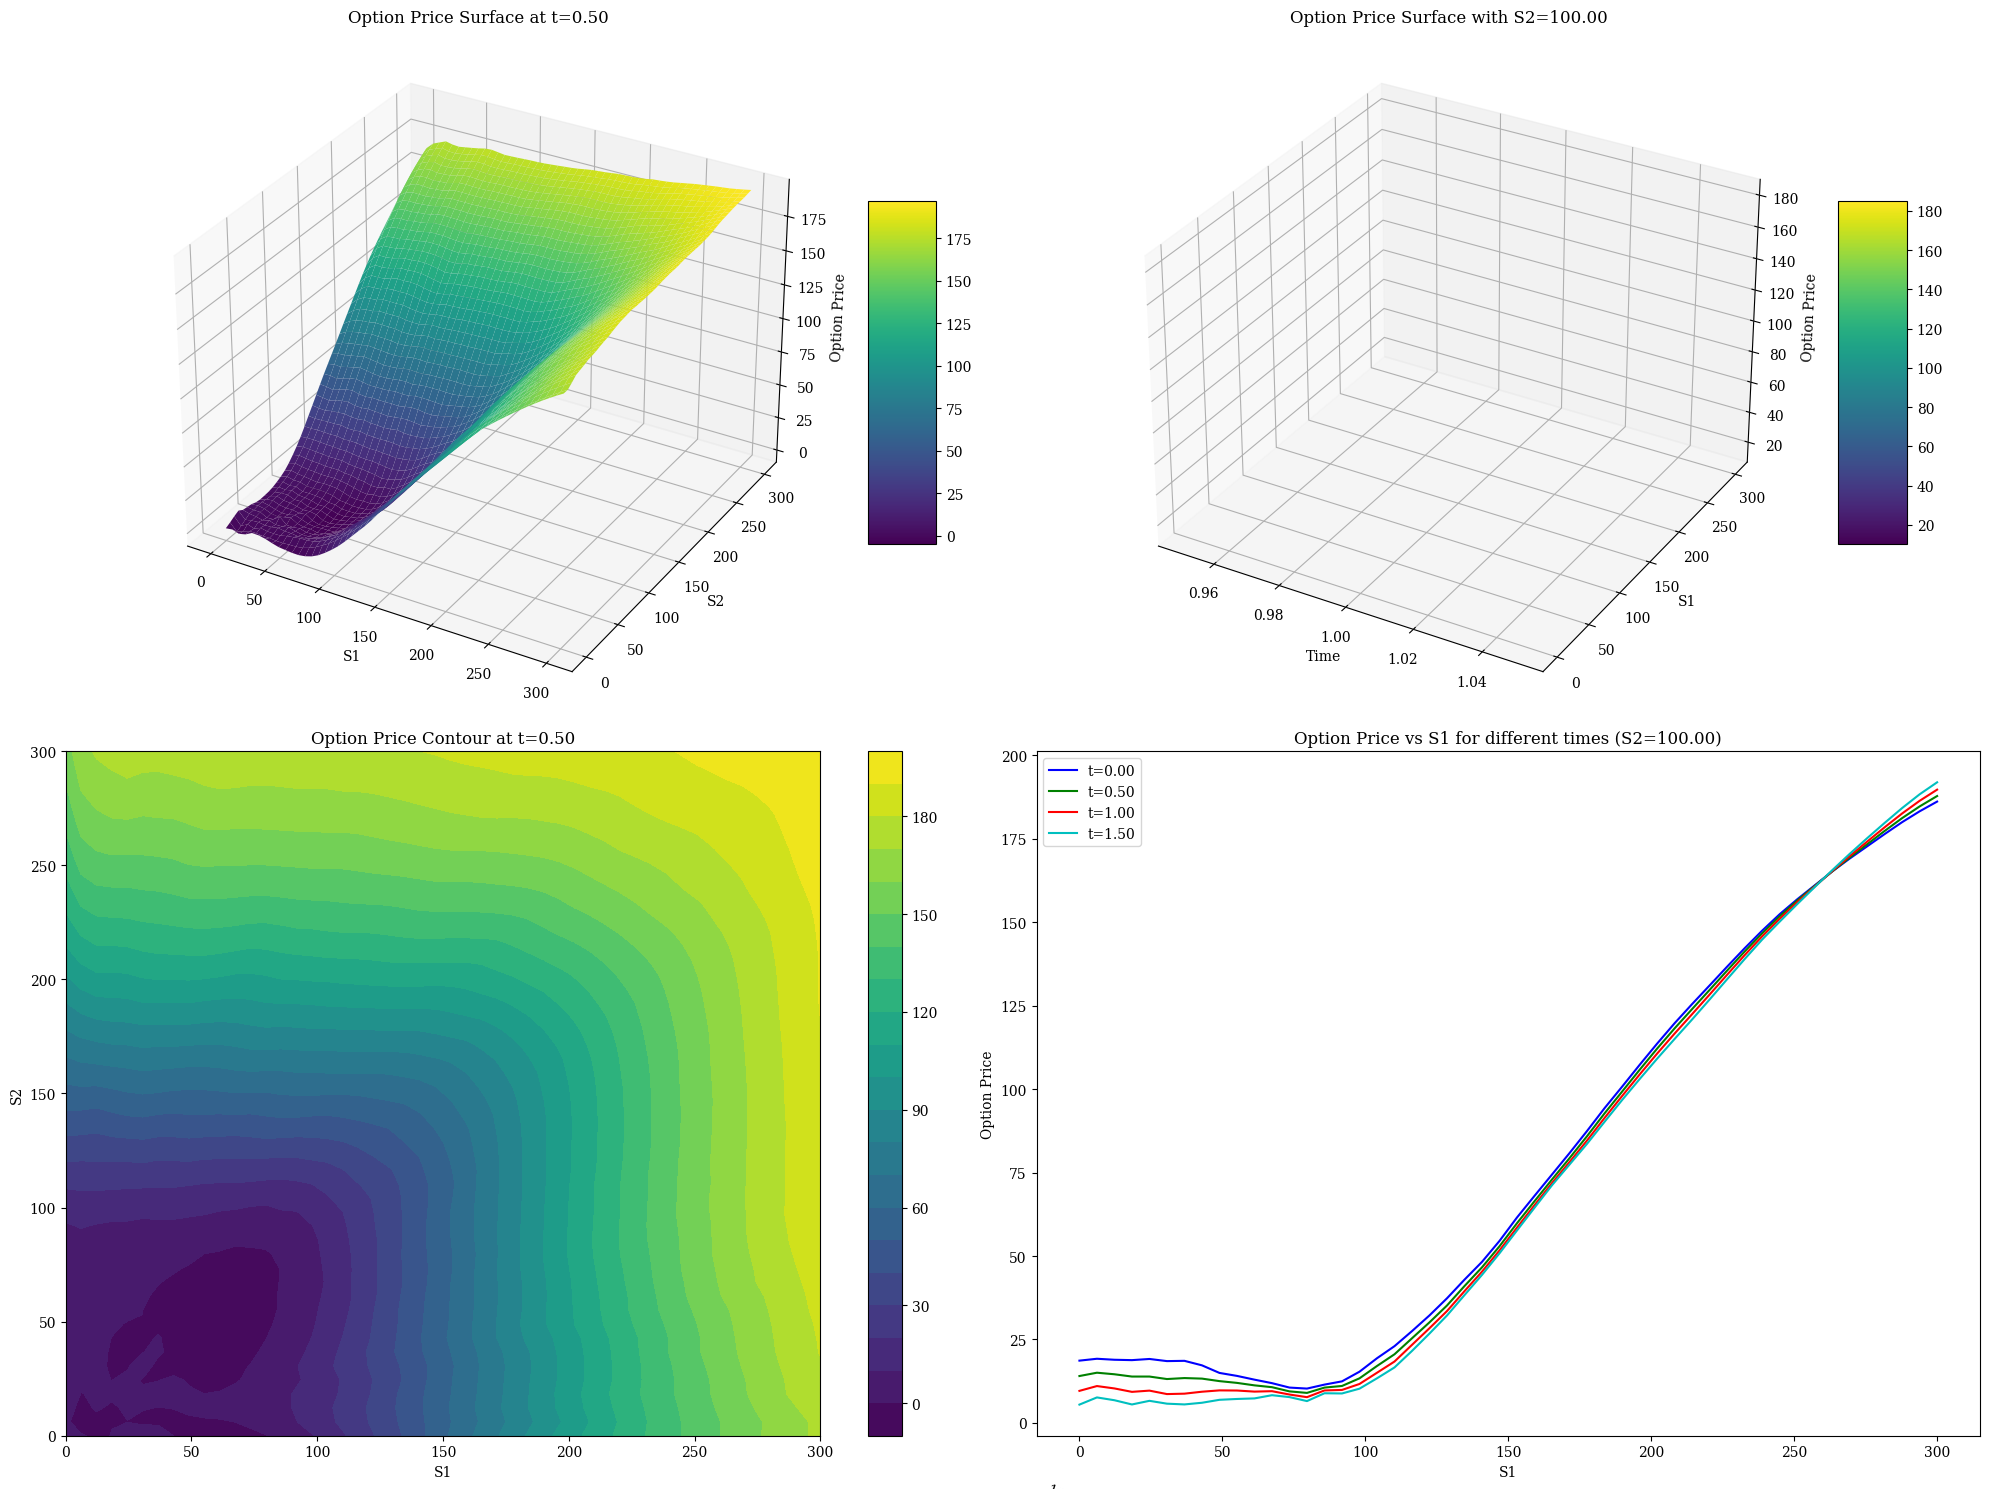

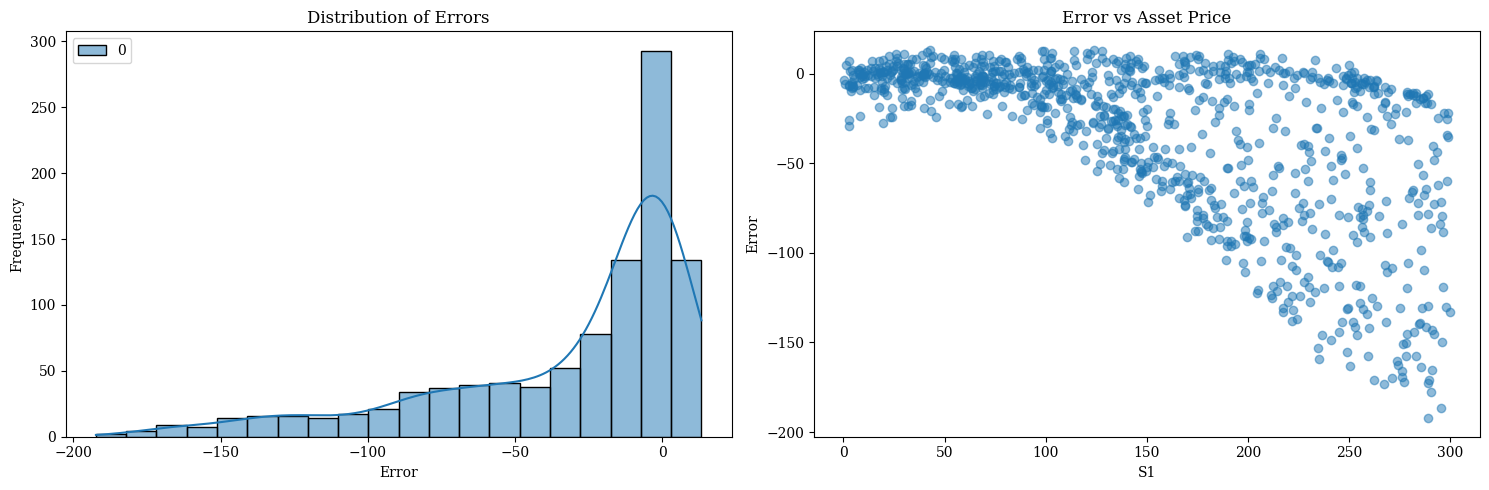

In [87]:
# After training your model, call:
animation_frames = create_visualizations(model)

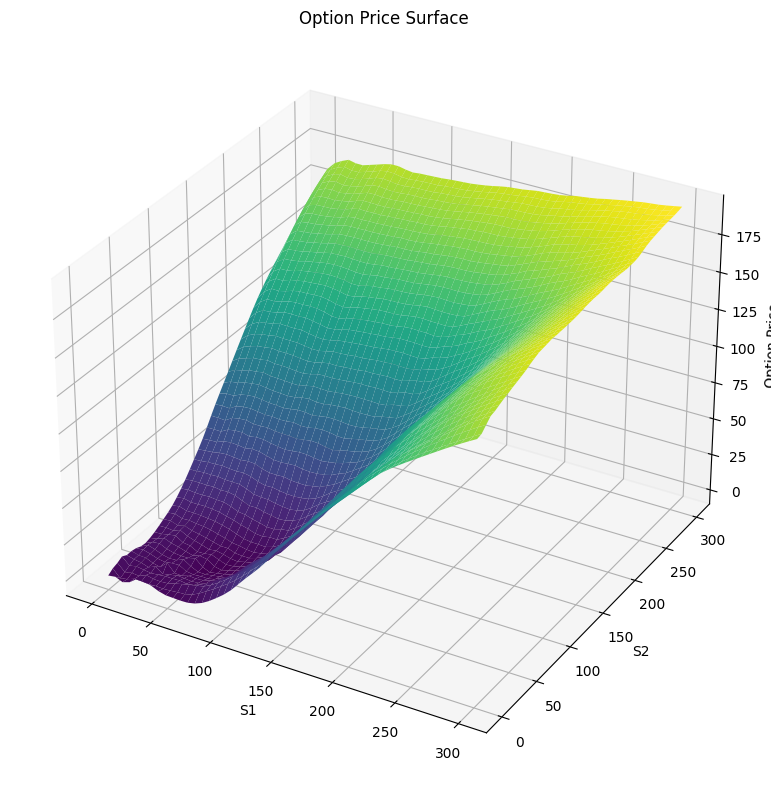

Animation frames saved successfully!


c:\Users\Rujul\AppData\Local\Programs\PythonCodingPack\lib\site-packages\numpy\lib\npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [50]:
# Plot the option price surface

S_1, S_2 = np.meshgrid(S_plot, S_plot)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_1, S_2, animation_frames[0][1], cmap='viridis')
ax.set_xlabel('S1')
ax.set_ylabel('S2')
ax.set_zlabel('Option Price')
ax.set_title('Option Price Surface')
plt.tight_layout()
if saveFigure:
    plt.savefig('option_price_surface.png')
plt.show()

# Save animation frames

if saveOutput:
    np.save('animation_frames.npy', animation_frames)
    print('Animation frames saved successfully!')

    


## Plot results

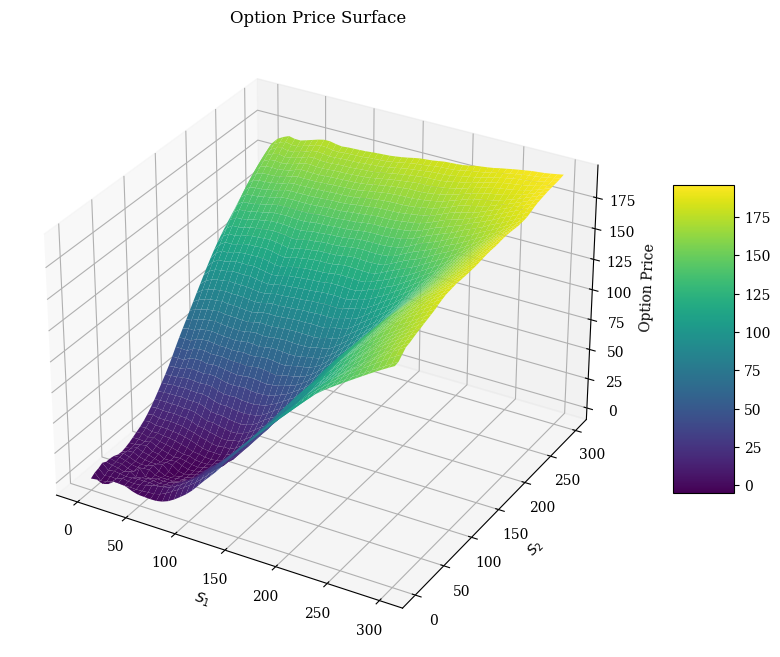

<Figure size 640x480 with 0 Axes>

In [53]:
# Disable LaTeX rendering in matplotlib
plt.rcParams['text.usetex'] = False

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# You can still use custom fonts without LaTeX, so we retain the serif font setting.
plt.rc('font', family='serif')

# Create the figure
fig = plt.figure(figsize=(12, 8))

# Create the 3D plot
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(S_1, S_2, animation_frames[0][1], cmap='viridis')

# Set the axis labels
ax.set_xlabel('$S_1$')
ax.set_ylabel('$S_2$')
ax.set_zlabel('Option Price')

# Set the title
ax.set_title('Option Price Surface')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Display the plot
plt.show()
    
# Adjust subplot spacing
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Save the figure if needed
if saveFigure:
    plt.savefig(figureName)
